In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
# from testCases_v3 import *
# from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
# 初始化一个2层网络：input layer[nx] + hidden layer[nh] + ouput layer[ny]
def initialize_parameters(nx, nh, ny):
    # random initialisation
    W1 = np.random.randn(nh, nx)*0.01
    b1 = np.zeros((nh, 1))
    W2 = np.random.randn(ny, nh)*0.01
    b2 = np.zeros((ny, 1))
    
    params = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    return params

In [3]:
params = initialize_parameters(2, 2, 1)
print(params)

{'W1': array([[-0.01461078,  0.00511223],
       [-0.01118106,  0.00574969]]), 'b1': array([[0.],
       [0.]]), 'W2': array([[0.00591343, 0.00537128]]), 'b2': array([[0.]])}


In [30]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    params = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        params["W"+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        params["b"+str(l)] = np.zeros((layer_dims[l], 1))
        
    return params

In [31]:
params = initialize_parameters_deep([3, 2, 2, 1])
print(params)

{'W1': array([[ 0.01788628,  0.0043651 ,  0.00096497],
       [-0.01863493, -0.00277388, -0.00354759]]), 'b1': array([[0.],
       [0.]]), 'W2': array([[-0.00082741, -0.00627001],
       [-0.00043818, -0.00477218]]), 'b2': array([[0.],
       [0.]]), 'W3': array([[-0.01313865,  0.00884622]]), 'b3': array([[0.]])}


## 正向传播

In [32]:
# Z[l] = W[l]A[l-1] + b[l]
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    
    cache = (A, W, b)
    return Z, cache

In [33]:
A, W, b = linear_forward_test_case()

Z, cache = linear_forward(A, W, b)
print(Z)

[[ 3.26295337 -1.23429987]]


In [34]:
# A[l] = g[l](Z[l])
def linear_activation_forward(A_prev, W, b, act):
    if act == "sigmoid":
        Z, lnr_cache = linear_forward(A_prev, W, b)
        A, act_cache = sigmoid(Z)
    elif act == "relu":
        Z, lnr_cache = linear_forward(A_prev, W, b)
        A, act_cache = relu(Z)
    
    # cache: A_prev, W, b, Z
    cache = (lnr_cache, act_cache)
    return A, cache

In [35]:
A_prev, W, b = linear_activation_forward_test_case()
A, cache = linear_activation_forward(A_prev, W, b, act="sigmoid")
print("sigmoid A="+str(A))
A, cache = linear_activation_forward(A_prev, W, b, act="relu")
print("relu A="+str(A))

sigmoid A=[[0.96890023 0.11013289]]
relu A=[[3.43896131 0.        ]]


In [36]:
def model_forward(X, params):
    caches = []
    A = X
    L = len(params) // 2
    
    for l in range(1, L):
        A_prev = A
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, act="relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, params["W"+str(L)], params["b"+str(L)], act="sigmoid")
    caches.append(cache)
    
    return AL, caches

In [37]:
X, params = L_model_forward_test_case()
AL, caches = model_forward(X, params)
print("AL = "+str(AL))
print("caches length: "+str(len(caches)))

AL = [[0.17007265 0.2524272 ]]
caches length: 2


# 反向传播

In [40]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [41]:
dZ, cache = linear_backward_test_case()
dA_prev, dW, db = linear_backward(dZ, cache)
print(str(dA_prev)+", "+str(dW)+", "+str(db))

[[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]], [[-0.10076895  1.40685096  1.64992505]], [[0.50629448]]


In [44]:
def linear_activation_backward(dA, cache, act):
    lnr_cache, act_cache = cache
    
    if act=="relu":
        dZ = relu_backward(dA, act_cache)
        dA_prev, dW, db = linear_backward(dZ, lnr_cache)
    elif act=="sigmoid":
        dZ = sigmoid_backward(dA, act_cache)
        dA_prev, dW, db = linear_backward(dZ, lnr_cache)
    
    return dA_prev, dW, db

In [45]:
AL, lnr_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(AL, lnr_cache, "sigmoid")
print("[sigmoid] dA_prev: "+str(dA_prev)+", dW: "+str(dW)+", db: "+str(db))

dA_prev, dW, db = linear_activation_backward(AL, lnr_cache, "relu")
print("[relu] dA_prev: "+str(dA_prev)+", dW: "+str(dW)+", db: "+str(db))

[sigmoid] dA_prev: [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]], dW: [[ 0.10266786  0.09778551 -0.01968084]], db: [[-0.05729622]]
[relu] dA_prev: [[ 0.44090989 -0.        ]
 [ 0.37883606 -0.        ]
 [-0.2298228   0.        ]], dW: [[ 0.44513824  0.37371418 -0.10478989]], db: [[-0.20837892]]


In [46]:
def model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # loss func, I = -(yloga + (1-y)*log(1-a))
    dAL = -np.divide(Y, AL) + np.divide(1-Y, 1-AL)
    
    cache = caches[L-1]
    grads["dA"+str(L)], grads["dW"+str(L)], grads["db"+str(L)] = linear_activation_backward(dAL, cache, act="sigmoid")
    
    for l in reversed(range(L-1)):
        # 第l+1层，在caches中索引为l
        cache  = caches[l]
        dA_prev, dW, db = linear_activation_backward(grads["dA"+str(l+2)], cache, act="relu")
        grads["dA"+str(l+1)] = dA_prev
        grads["dW"+str(l+1)] = dW
        grads["db"+str(l+1)] = db
    
    return grads

In [47]:
AL, Y, caches = L_model_backward_test_case()
grads = model_backward(AL, Y, caches)
print(str(grads["dA1"]) + ", " + str(grads["dW1"]) +", "+ str(grads["db1"]))

[[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]], [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]], [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]


# 参数更新

In [38]:
def compute_cost_func(AL, Y):
    m = AL.shape[1]
    cost = -1/m * np.sum((Y*np.log(AL) + (1-Y)*np.log(1-AL)), axis=1, keepdims=True)
    cost = np.squeeze(cost)
    return cost

In [39]:
Y, AL = compute_cost_test_case()
cost = compute_cost_func(AL, Y)
print(cost)

0.41493159961539694


In [48]:
def update_params(params, grads, learning_rate):
    L = len(params)//2
    for l in range(L):
        params["W"+str(l+1)] = params["W"+str(l+1)] - learning_rate * grads["dW"+str(l+1)]
        params["b"+str(l+1)] = params["b"+str(l+1)] - learning_rate * grads["db"+str(l+1)]
        
    return params

In [49]:
params, grads = update_parameters_test_case()
params = update_params(params, grads, learning_rate=0.1)
print("W1: " + str(params["W1"]) + "; b1: " + str(params["b1"]) + "; W2: " + str(params["W2"]) + "; b2: " + str(params["b2"]))

W1: [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]; b1: [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]; W2: [[-0.55569196  0.0354055   1.32964895]]; b2: [[-0.84610769]]


# 加载数据

In [3]:
# from lr_utils import load_dataset
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1. It's a cat picture.


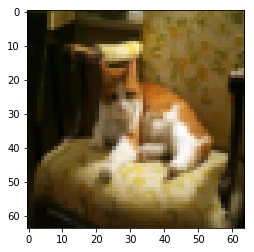

In [4]:
plt.imshow(train_x_orig[7])
print("y = " + str(train_y[0, 7]) + ". It's a " + classes[train_y[0, 7]].decode("utf-8") + " picture.")

In [5]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print("Training set size: "+str(m_train))
print("Test set size: "+str(m_test))
print("Image size: ("+str(num_px)+", "+str(num_px)+", 3)")

Training set size: 209
Test set size: 50
Image size: (64, 64, 3)


In [6]:
# 展平数组(n, n, 3) -> (n*n*3, 1)
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.
print("train set size: x, "+str(train_x.shape)+"; y: "+str(train_y.shape))
print("test set size: "+str(test_x.shape)+"; y: "+str(test_y.shape))

train set size: x, (12288, 209); y: (1, 209)
test set size: (12288, 50); y: (1, 50)


# 构建模型

In [7]:
# input+4层模型，各层参数如下
layer_dims = [12288, 20, 7, 5, 1]

In [8]:
def L_layer_model(X, Y, layer_dims, learning_rate=0.0075, iterations=3000, print_cost=False):
    np.random.seed(1)
    costs = []
    params = initialize_parameters_deep(layer_dims)
    
    for i in range(0, iterations):
        # FP
        AL, caches = L_model_forward(X, params)
        cost = compute_cost(AL, Y)
        # BP
        grads = L_model_backward(AL, Y, caches)
        # update params
        params = update_parameters(params, grads, learning_rate)
        
        if print_cost and i%100==0:
            costs.append(cost)
            print("cost after %i iterations is %f" % (i, cost))
    
    # plot costs
    plt.plot(np.squeeze(costs))
    plt.ylabel("cost")
    plt.xlabel("iterations per 100")
    plt.title("learning_rate is "+str(learning_rate))
    plt.show()
    
    return params

cost after 0 iterations is 0.771749
cost after 100 iterations is 0.672053
cost after 200 iterations is 0.648263
cost after 300 iterations is 0.611507
cost after 400 iterations is 0.567047
cost after 500 iterations is 0.540138
cost after 600 iterations is 0.527930
cost after 700 iterations is 0.465477
cost after 800 iterations is 0.369126
cost after 900 iterations is 0.391747
cost after 1000 iterations is 0.315187
cost after 1100 iterations is 0.272700
cost after 1200 iterations is 0.237419
cost after 1300 iterations is 0.199601
cost after 1400 iterations is 0.189263
cost after 1500 iterations is 0.161189
cost after 1600 iterations is 0.148214
cost after 1700 iterations is 0.137775
cost after 1800 iterations is 0.129740
cost after 1900 iterations is 0.121225
cost after 2000 iterations is 0.113821
cost after 2100 iterations is 0.107839
cost after 2200 iterations is 0.102855
cost after 2300 iterations is 0.100897
cost after 2400 iterations is 0.092878


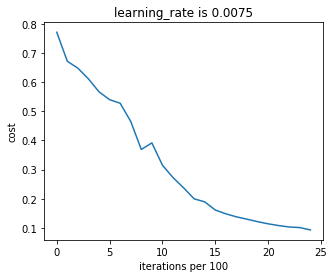

In [9]:
parameters = L_layer_model(train_x, train_y, layer_dims, learning_rate=0.0075, iterations=2500, print_cost=True)

In [66]:
def predict(X, Y, params):
    m = X.shape[1]
    n = len(params) // 2
    p = np.zeros((1, m))
    
    AL, cache = model_forward(X, params)
    for i in range(0, AL.shape[1]):
        if AL[0][i] > 0.5:
            p[0][i] = 1
        else:
            p[0][i] = 0
    
    print("Accuracy: " + str(np.sum((p == Y)/m)))
    return p

In [13]:
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9856459330143539
Accuracy: 0.8
